In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output


# Callback invoked by the IPython interact method for scrolling through image stacks of
# the two images being registered.
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))


def window_level_transform(image, window, level):
    """Przekształca wartości intensywności obrazu za pomocą window/level."""
    min_intensity = level - (window / 2)
    max_intensity = level + (window / 2)
    transformed_image = np.clip((image - min_intensity) / (max_intensity - min_intensity), 0, 1)
    return transformed_image
    # return image

def display_registered_images_with_alpha(image_z, alpha, fixed, moving, fixed_wl, moving_wl):
    """Wyświetla obrazy z nakładaniem, uwzględniając window/level."""
    # Zastosowanie window/level do obrazów
    fixed_transformed = window_level_transform(fixed[:, :, image_z],  fixed_wl[0], fixed_wl[1])
    moving_transformed = window_level_transform(moving[:, :, image_z], moving_wl[0], moving_wl[1])

    # Nakładanie obrazów z uwzględnieniem współczynnika alpha
    img = (1.0 - alpha) * fixed_transformed + alpha * moving_transformed
    
    # Wyświetlanie
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")
    # plt.title("Nakładanie z Alpha i Window/Level")
    plt.show()

In [2]:
import SimpleITK as sitk

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing

# Utility method that either downloads data from the network or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory.
import os

OUTPUT_DIR = "Output/polaczenie"

from ipywidgets import interact, fixed

# Enable display of HTML.
from IPython.display import display, HTML

# Plots will be inlined.
%matplotlib inline

# Callbacks for plotting registration progress.
import registration_callbacks


def save_transform_and_image(transform, fixed_image, moving_image, outputfile_prefix):
    """
    Write the given transformation to file, resample the moving_image onto the fixed_images grid and save the
    result to file.

    Args:
        transform (SimpleITK Transform): transform that maps points from the fixed image coordinate system to the moving.
        fixed_image (SimpleITK Image): resample onto the spatial grid defined by this image.
        moving_image (SimpleITK Image): resample this image.
        outputfile_prefix (string): transform is written to outputfile_prefix.tfm and resampled image is written to
                                    outputfile_prefix.mha.
    """
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)

    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetTransform(transform)
    sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix + ".mha")
    sitk.WriteTransform(transform, outputfile_prefix + ".tfm")
    return resample.Execute(moving_image)

def DICOM_series_dropdown_callback(fixed_image, moving_image, series_dictionary):
    """
    Callback from dropbox which selects the two series which will be used for registration.
    The callback prints out some information about each of the series from the meta-data dictionary.
    For a list of all meta-dictionary tags and their human readable names see DICOM standard part 6,
    Data Dictionary (http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf)
    """
    # The callback will update these global variables with the user selection.
    global selected_series_fixed
    global selected_series_moving

    img_fixed = sitk.ReadImage(series_dictionary[fixed_image][0])
    img_moving = sitk.ReadImage(series_dictionary[moving_image][0])

    # There are many interesting tags in the DICOM data dictionary, display a selected few.
    tags_to_print = {
        "0010|0010": "Patient name: ",
        "0008|0060": "Modality: ",
        "0008|0021": "Series date: ",
        "0008|0031": "Series time:",
        "0008|0070": "Manufacturer: ",
    }
    html_table = []
    html_table.append(
        "<table><tr><td><b>Tag</b></td><td><b>Fixed Image</b></td><td><b>Moving Image</b></td></tr>"
    )
    for tag in tags_to_print:
        fixed_tag = ""
        moving_tag = ""
        try:
            fixed_tag = img_fixed.GetMetaData(tag)
        except:  # ignore if the tag isn't in the dictionary
            pass
        try:
            moving_tag = img_moving.GetMetaData(tag)
        except:  # ignore if the tag isn't in the dictionary
            pass
        html_table.append(
            "<tr><td>"
            + tags_to_print[tag]
            + "</td><td>"
            + fixed_tag
            + "</td><td>"
            + moving_tag
            + "</td></tr>"
        )
    html_table.append("</table>")
    display(HTML("".join(html_table)))
    selected_series_fixed = fixed_image
    selected_series_moving = moving_image

In [3]:
import SimpleITK as sitk

%run setup_for_testing

import os
import numpy as np

from ipywidgets import interact, fixed

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

%matplotlib widget
import gui


# This is the registration configuration which we use in all cases. The only parameter that we vary
# is the initial_transform.
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        # estimateLearningRate=registration_method.Once,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    final_transform = registration_method.Execute(fixed_image, moving_image)
    print(f"Final metric value: {registration_method.GetMetricValue()}")
    print(
        f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
    )
    return (final_transform, registration_method.GetMetricValue())

#### Loading data

In [4]:
#To use other data, upload it to the directory according to the instructions from data provider and use instead.

data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))

# 'selected_series_moving/fixed' will be updated by the interact function.
selected_series_fixed = ""
selected_series_moving = ""

# Directory contains multiple DICOM studies/series, store the file names
# in dictionary with the key being the series ID.
reader = sitk.ImageSeriesReader()
series_file_names = {}
series_IDs = list(reader.GetGDCMSeriesIDs(data_directory))  # list of all series

if series_IDs:  # check that we have at least one series
    for series in series_IDs:
        series_file_names[series] = reader.GetGDCMSeriesFileNames(
            data_directory, series
        )
    interact(
        DICOM_series_dropdown_callback,
        fixed_image=series_IDs,
        moving_image=series_IDs,
        series_dictionary=fixed(series_file_names),
    )
else:
    print("Data directory does not contain any DICOM series.")

Fetching CIRS057A_MR_CT_DICOM/readme.txt


interactive(children=(Dropdown(description='fixed_image', options=('1.2.840.113619.2.290.3.3233817346.783.1399…

In [5]:
# Read the data based on the user's selection.
fixed_image = sitk.ReadImage(series_file_names[selected_series_fixed], sitk.sitkFloat32)
moving_image = sitk.ReadImage(series_file_names[selected_series_moving], sitk.sitkFloat32)


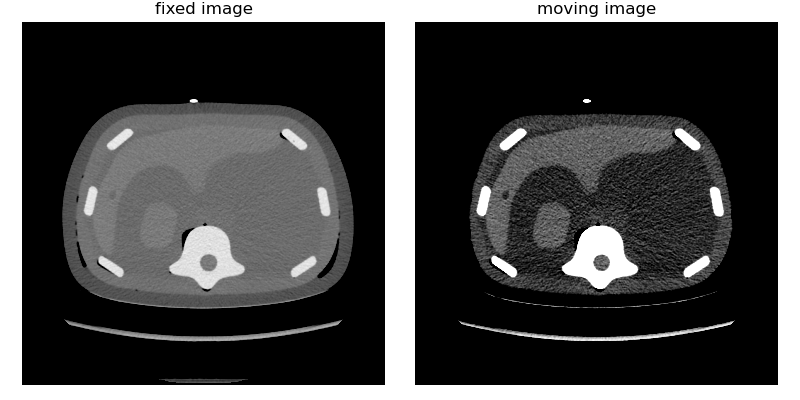

In [6]:
# To provide a reasonable display we need to window/level the images. By default we could have used the intensity
# ranges found in the images [SimpleITK's StatisticsImageFilter], but these are not the best values for viewing.

ct_window_level = [932, 180]
mr_window_level = [286, 143]

                       
gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed image", "moving image"],
    figure_size=(8, 4),
    window_level_list=[ct_window_level, mr_window_level],
    intensity_slider_range_percentile=[0, 100],
);


### Example of finding final transform
The following steps outline the process of determining the transform required to register the images effectively. This method involves selecting an appropriate transformation type, configuring the key parameters, and utilizing the functions defined earlier.

In [7]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)

Final metric value: -1.0199962724414617
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


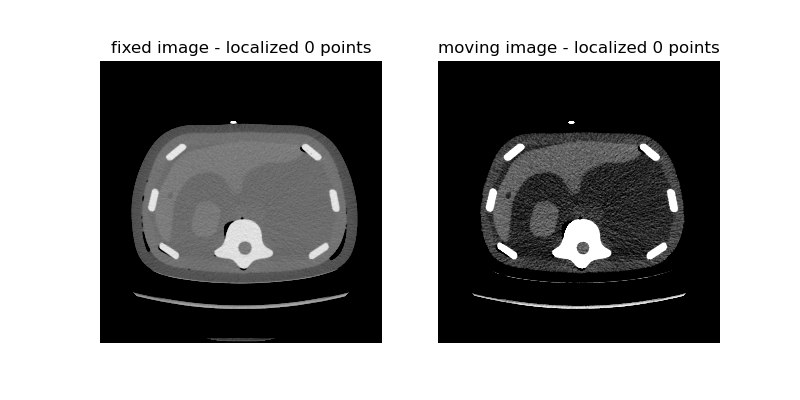

In [8]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

## Setting up initial transform

Initialization is a crucial step in most image registration algorithms, as these methods are typically formulated as iterative optimization problems. The choice of initialization significantly impacts both the runtime and the likelihood of converging to the correct solution. Ideally, the transformation should be initialized close to the true alignment, ensuring faster and more reliable convergence.

Problem-specific initialization often yields better results compared to generic approaches. For instance, when the two images differ significantly in perspective, adjusting the initial rotation can improve the algorithm's ability to align the images effectively and converge more quickly to the optimal transform. To evaluate how the initial rotation influences the final transformation, run the code provided below.

In [9]:
from multiprocessing.pool import ThreadPool
from functools import partial
all_orientations = {
    "x=0, y=0, z=0": (0.0, 0.0, 0.0),
    "x=0, y=0, z=90": (0.0, 0.0, np.pi/2),
    "x=0, y=0, z=180": (0.0, 0.0, np.pi),
    "x=0, y=0, z=270": (0.0, 0.0, 3*np.pi/2),

    "x=0, y=180, z=0": (0.0, np.pi, 0.0),
    "x=0, y=180, z=180": (0.0, np.pi, np.pi),
}


initial_transform = sitk.Euler3DTransform(
    sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )
)


# This function evaluates the metric value in a thread safe manner
def evaluate_metric(current_rotation, tx, f_image, m_image):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    current_transform = sitk.Euler3DTransform(tx)
    current_transform.SetRotation(*current_rotation)
    registration_method.SetInitialTransform(current_transform)
    res = registration_method.MetricEvaluate(f_image, m_image)
    return res


p = ThreadPool(len(all_orientations) + 1)
orientations_list = [(0, 0, 0)] + list(all_orientations.values())
all_metric_values = p.map(
    partial(
        evaluate_metric, tx=initial_transform, f_image=fixed_image, m_image=moving_image
    ),
    orientations_list,
)
best_orientation = orientations_list[np.argmin(all_metric_values)]
print("best orientation is: " + str(best_orientation))

best orientation is: (0, 0, 0)


In [10]:
initial_transform.SetRotation(*best_orientation)
final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)

Final metric value: -1.1281428542195282
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [ ]:
print(final_transform)

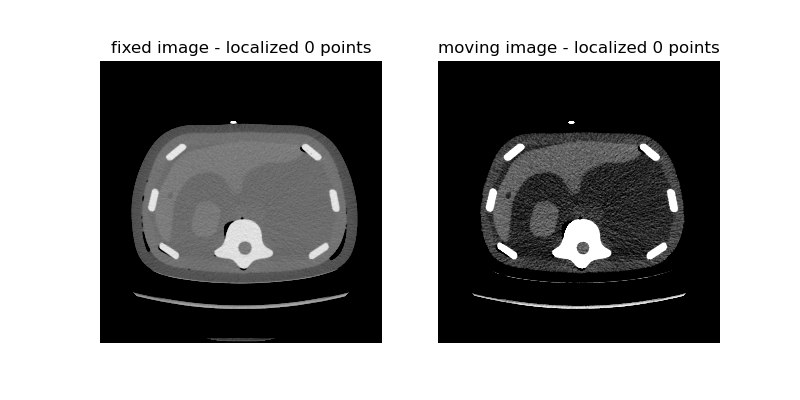

In [11]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

### Comparison of different methods

In [12]:
# initial_transform.SetRotation(*best_orientation)
# final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)
import pandas as pd
transformation_methods = [
    sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(),sitk.CenteredTransformInitializerFilter.GEOMETRY),
    sitk.TranslationTransform(fixed_image.GetDimension()),
    sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Similarity3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY),
    sitk.AffineTransform(sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.AffineTransform(fixed_image.GetDimension()))),
     sitk.VersorRigid3DTransform(sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.VersorRigid3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY))
]

# Funkcja do testowania rejestracji z różnymi metodami
metrics_results = []
images = []
for i, initial_transform in enumerate(transformation_methods):
    print(f"\nTesting method {i + 1}/{len(transformation_methods)}")
    try:
        fixed_image = sitk.ReadImage(series_file_names[selected_series_fixed], sitk.sitkFloat32)
        moving_image = sitk.ReadImage(series_file_names[selected_series_moving], sitk.sitkFloat32)

        # uncomment code below if you want to try using setting rotation
        # if i == 0:
        #     initial_transform.SetRotation(*best_orientation)
        # elif i == 2:
        #     non_zero_index = next((i for i, x in enumerate(best_orientation) if x != 0), None)

        #     if non_zero_index is not None:
        #         angle_in_radians = np.radians(best_orientation[non_zero_index])
        
        #         new_tuple = tuple(1 if i == non_zero_index else x for i, x in enumerate(best_orientation))
        #         initial_transform.SetRotation(new_tuple, angle_in_radians)
        
        final_transform, metric_value = multires_registration(fixed_image, moving_image, initial_transform)
        metrics_results.append({
            'Method': type(initial_transform).__name__,
            'Metric Value': metric_value
        })
        images.append((fixed_image, moving_image, final_transform))
    except Exception as e:
        print(f"Error with method {type(initial_transform).__name__}: {e}")
        metrics_results.append({
            'Method': type(initial_transform).__name__,
            'Metric Value': None
        })

# Save results to csv file
metrics_df = pd.DataFrame(metrics_results)
output_path = os.path.join(data_directory, 'registration_metrics.csv')
metrics_df.to_csv(output_path, index=False)

print(f"\nResults saved to {output_path}")
print(metrics_df)



Testing method 1/5
Final metric value: -0.47771855521148554
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.

Testing method 2/5
Final metric value: -0.7643415728482144
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 16.

Testing method 3/5
Final metric value: -1.0427436828294616
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.

Testing method 4/5
Final metric value: -0.9421417859958919
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 14.

Testing method 5/5
Final metric value: -0.8179666604032887
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.

Results saved to C:\Users\Martyna\SP\SimpleITK-Notebooks\Data\CIRS057A_MR_CT_DICOM\registration_metrics.csv
                   Method  Metr

In [13]:
i = 0
for fixed_image, moving_image, final_transform in images:
    save_transform_and_image(
    final_transform,
    fixed_image,
    moving_image,
    os.path.join(OUTPUT_DIR, f"finalAlignment_{i}"),
    )
    i+=1


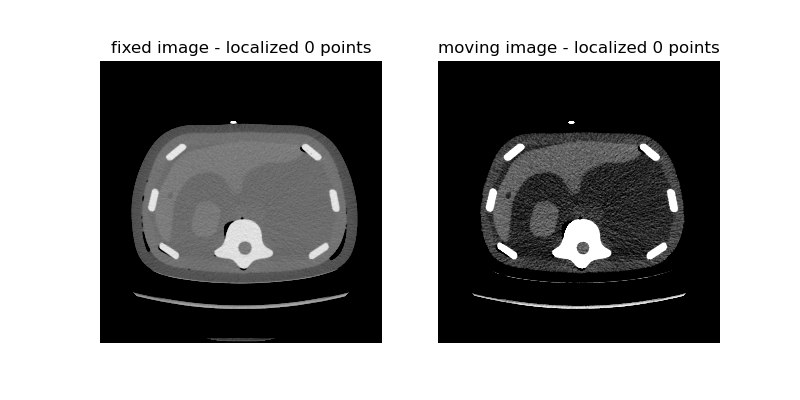

In [14]:
# debug to see if it works - it does !
gui.RegistrationPointDataAquisition(
            images[0][0],
            images[0][1],
            figure_size=(8, 4),
            known_transformation=images[0][2],
            fixed_window_level=ct_window_level,
            moving_window_level=mr_window_level,
        );